In [2]:
# Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load configuration
data_dir = None
%run ../../../config.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/max/proj/WirelessIncome
Data directory: /Users/max/proj/WirelessIncome/data


In [3]:
# Paths to parquet files produced by the 2019 Q1 notebooks
mobile_path = f"{data_dir}/uss_mobile_2019q1.parquet"
tracts_path = f"{data_dir}/tracts_with_income_2019.parquet"

# Load datasets
mobile_df = pd.read_parquet(mobile_path)
tracts_gdf = gpd.read_parquet(tracts_path)

# Convert mobile_df to GeoDataFrame using existing geometry field
import shapely.wkb

# Convert WKB geometry to shapely objects
mobile_df['geometry'] = mobile_df['geometry'].apply(lambda x: shapely.wkb.loads(x) if x else None)

# Create GeoDataFrame with existing geometry
mobile_gdf = gpd.GeoDataFrame(mobile_df, geometry='geometry', crs="EPSG:4326")

print(f"Mobile data rows: {len(mobile_gdf)}")
print(f"Tracts: {len(tracts_gdf)}")

# Reproject to a common CRS for spatial operations
mobile_gdf = mobile_gdf.to_crs(epsg=3857)
tracts_gdf = tracts_gdf.to_crs(epsg=3857)

# Spatial join: assign each speed point to a tract
joined = gpd.sjoin(mobile_gdf, tracts_gdf[["GEOID", "median_income", "geometry"]], how="inner", predicate="within")

print(f"Joined rows: {len(joined)}")
joined.head()

Mobile data rows: 783624
Tracts: 72438
Joined rows: 470898


,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry,index_right,GEOID,median_income
5222,63793,7107,24,1,1,2019,1,mobile,POINT (-13700267.202 6273034.037),42045,53073011000,43510.0
5223,18199,537,34,1,1,2019,1,mobile,POINT (-13699655.705 6272422.541),42045,53073011000,43510.0
6561,17755,12699,32,1,1,2019,1,mobile,POINT (-13664188.924 6274868.526),22241,53073010401,75230.0
6562,70808,6169,32,1,1,2019,1,mobile,POINT (-13663577.428 6274868.526),22241,53073010401,75230.0
6563,34774,23259,32,1,1,2019,1,mobile,POINT (-13665411.917 6273645.534),22241,53073010401,75230.0


In [7]:
# Aggregation function and OLS helper
import numpy as np

def aggregate_speeds(joined_gdf, by="GEOID", var="avg_d_kbps", stat="mean"):
    """
    Aggregate speeds by tract with chosen statistic.
    stat: 'mean' | 'median'
    var: column in joined_gdf for dependent variable (e.g., 'avg_d_kbps', 'avg_u_kbps')
    """
    agg_dict = {
        'avg_d_kbps': stat,
        'avg_u_kbps': stat,
        'avg_lat_ms': stat,
        'tests': 'sum',
        'devices': 'sum',
        'median_income': 'first'
    }
    
    return joined_gdf.groupby(by).agg(agg_dict).reset_index()
    
# Example: aggregate using mean download speed and run OLS
agg_df = aggregate_speeds(joined, var="avg_d_kbps", stat="mean")
agg_df.head()

,GEOID,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,median_income
0,01001020100,9997.0,16228.000000,30.000000,1,1,60208.0
1,01001020200,6558.0,6200.000000,34.500000,16,2,43958.0
2,01001020300,23738.0,9936.666667,30.833333,7,6,55345.0
3,01001020400,12795.2,9978.000000,38.000000,6,6,59663.0
4,01001020500,33217.2,9594.600000,42.933333,27,25,66108.0


<Axes: >

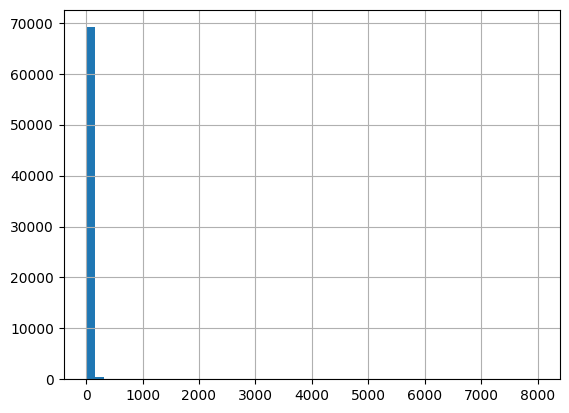

In [8]:
agg_df.tests.hist(bins=50)

In [9]:
agg_df.avg_d_kbps.describe()

count     69789.000000
mean      32834.172392
std       19364.633166
min          10.000000
25%       19629.000000
50%       29927.625000
75%       42322.300000
max      353385.000000
Name: avg_d_kbps, dtype: float64

<Axes: >

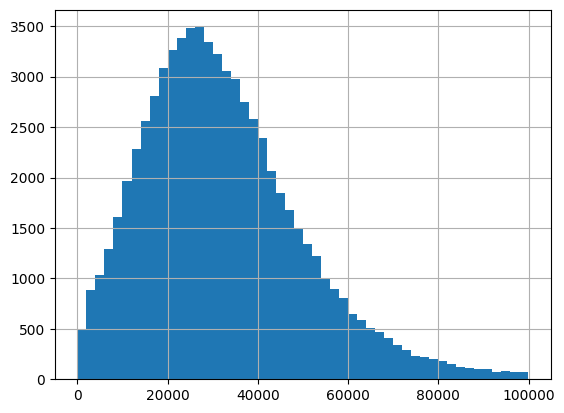

In [10]:
agg_df[agg_df.avg_d_kbps < 100_000].avg_d_kbps.hist(bins=50)

                            OLS Regression Results                            
Dep. Variable:             avg_d_kbps   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3338.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:02:09   Log-Likelihood:            -7.8630e+05
No. Observations:               69789   AIC:                         1.573e+06
Df Residuals:                   69787   BIC:                         1.573e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.461e+04    159.381    154.392

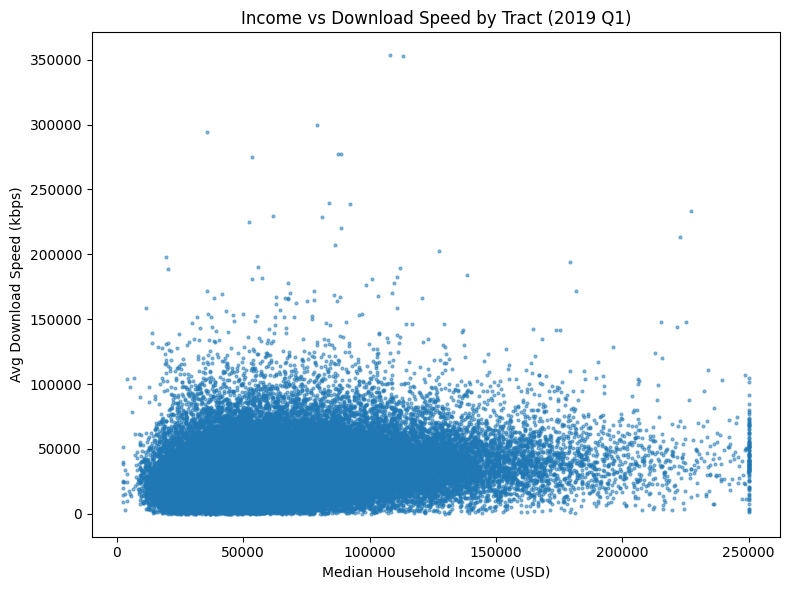

In [11]:
x_var = "median_income"
y_var = "avg_d_kbps"

X = sm.add_constant(agg_df[x_var])  # add intercept

y = agg_df[y_var]
model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(agg_df[x_var], agg_df[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2019 Q1)")
plt.tight_layout()
plt.show()